## Kütüphaneleri ve Veriyi Yükleme

Bu notebook'ta redditten çekilen verilerin analiz ve ön işleme çalışmaları gerçekleştirildi

In [11]:
import pandas as pd
from tqdm import tqdm

In [12]:
data = pd.read_excel('../Data/selectivemutism_translated_to_tr.xlsx')
data = data[data['Result'] == 'yes']

In [13]:
data.head()

,Result,Text,Translated_Text
0,yes,I can speak 'normally' to 6 people. I feel anx...,6 kişiye 'normal' konuşabiliyorum. Onlarla kon...
1,yes,scared of raising their hand in class...scared...,Sınıfta ellerini kaldırmaktan korkuyorlar... E...
2,yes,"I cannot even talk to them with my full voice,...","Onlarla tam sesimle bile konuşamıyorum, onlarl..."
3,yes,I had selective mutism as a kid for 10 years w...,Ailemin dışında konuşamadığım 10 yıl boyunca s...
4,yes,"Growing up, I would get yelled at in the middl...","Büyürken, konuşmadığım için odadaki diğer 50 ö..."


In [14]:
data.shape

(1547, 3)

## Ön İşleme Aşamaları

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
data.isnull().sum()

Result             0
Text               0
Translated_Text    0
dtype: int64

## Her Metin İçin Kelime Sayılarının Hesaplanması

In [17]:
data['Word_Count'] = data['Translated_Text'].apply(lambda x: len(x.split()))

In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Word_Count,1547.0,30.996768,17.329673,1.0,17.0,28.0,44.0,131.0


<function matplotlib.pyplot.axis(arg=None, /, *, emit=True, **kwargs)>

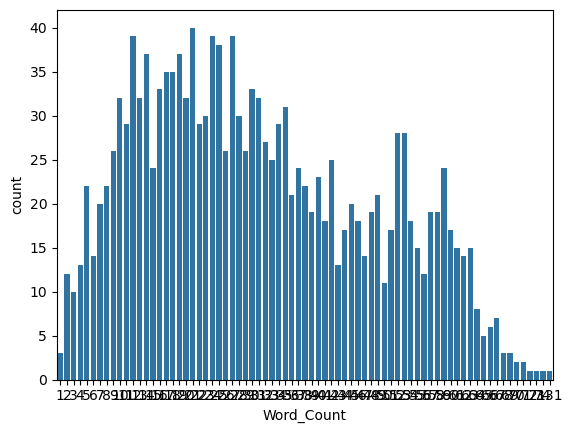

In [19]:
sns.countplot(x="Word_Count", data=data)
plt.axis

## Güvenlik Ayarlarını (Irkçı, cinsiyetçi mesajlar gibi) Ayarlama

In [21]:
safety_settings = [
  {

      "category": "HARM_CATEGORY_HARASSMENT",
      "threshold": "BLOCK_NONE"

  },
  {

      "category": "HARM_CATEGORY_HATE_SPEECH",
      "threshold": "BLOCK_NONE"

  },
  {

      "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
      "threshold": "BLOCK_NONE"

  },
  {

      "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
      "threshold": "BLOCK_NONE"

  }
]

## Çekilen Verileri LLM ile Sınıflandırma

In [22]:
import os
import time
import google.generativeai as genai
import re
import json

genai.configure(api_key="API-KEY") #Usey your api key

model = genai.GenerativeModel('gemini-1.5-flash',
                             safety_settings=safety_settings)

def submission_prediction(input_text: str):
    response = model.generate_content("""
    Sen verilen cümlenin bir hastanın, seçici dilsizlik hastalık belirtisinde olup olmadığını anlayan uzman bir psikologsun. 

    \n\n

    Aşağıdaki üçlü tırnaklar arasında verilen cümleyi analiz et. Aşağıdaki yönlendirmeler göre cevap ver:
    1. Eğer bu cümle *seçici dilsizlik* hastalığı yaşayan bir kişiye ait bir davranış, duygu veya ifade *içeriyorsa* aşağıda verilen JSON formtında dön:
        {"Result":"yes", "Text": <cümlenin_ham_hali>}

    2. Eğer bu cümle *seçici dilsizlik* hastalığı yaşayan bir kişiye ait bir davranış, duygu veya ifade *içermiyorsa* aşağıda verilen JSON formtında dön:
        {"Result":"no", "Text": <cümlenin_ham_hali>}

    \n\n
    Cümle: """ + input_text)
    try:
        pattern = re.compile(r'\{.*?\}', re.DOTALL)
        match = pattern.search(response.text)
        
        if match:
            response_json = json.loads(match.group(0))
            return response_json
        
        else:
            return {
                "Result":None,
                "Text":None
            }
            
    except Exception as err:
        print(err)
        return {
                "Result":None,
                "Text":None
            }


In [25]:
new_filtered_data_list = []

for translate_text in tqdm(data['Translated_Text'][len(new_filtered_data_list):], desc="Filtering Process"):

    response_json = submission_prediction(translate_text)
    time.sleep(4.1)
    new_filtered_data_list.append(response_json)

Filtering Process:   9%|█████▎                                                    | 141/1547 [16:44<2:45:35,  7.07s/it]

Expecting ',' delimiter: line 1 column 42 (char 41)


Filtering Process:  18%|██████████▏                                               | 273/1547 [32:47<2:36:11,  7.36s/it]

The `response.parts` quick accessor only works for a single candidate, but none were returned. Check the `response.prompt_feedback` to see if the prompt was blocked.


Filtering Process:  35%|███████████████████▊                                    | 547/1547 [1:05:57<1:54:02,  6.84s/it]

The `response.parts` quick accessor only works for a single candidate, but none were returned. Check the `response.prompt_feedback` to see if the prompt was blocked.


Filtering Process:  40%|██████████████████████▎                                 | 616/1547 [1:15:25<1:42:16,  6.59s/it]

Expecting ',' delimiter: line 1 column 48 (char 47)


Filtering Process:  64%|███████████████████████████████████▊                    | 988/1547 [1:58:49<1:07:13,  7.22s/it]


DeadlineExceeded: 504 Deadline Exceeded

In [27]:
pd.DataFrame(new_filtered_data_list).to_excel("../Data/selective_mutism_filtered_tr_data.xlsx", index = False)

## Filtrelenen Verilerin Analizi

In [4]:
filtered_data = pd.read_excel('../Data/selective_mutism_filtered_tr_data.xlsx')
filtered_data.head()

,Result,Text
0,yes,"Bu yorum, seçici dilsizliğin belirtilerine işa..."
1,no,Bu cümle seçici dilsizlik ile ilgili bir davra...
2,yes,"Cümle, seçici dilsizliğin temel belirtilerinde..."
3,yes,"Yorumda, kişinin 'ailemin dışında konuşamadığı..."
4,yes,"Cümle, seçici dilsizliğe işaret eden, kişisel ..."


In [5]:
filtered_data.shape

(1547, 2)

In [7]:
data.shape

(1547, 3)

In [8]:
filtered_data

,Result,Text
0,yes,"Bu yorum, seçici dilsizliğin belirtilerine işa..."
1,no,Bu cümle seçici dilsizlik ile ilgili bir davra...
2,yes,"Cümle, seçici dilsizliğin temel belirtilerinde..."
3,yes,"Yorumda, kişinin 'ailemin dışında konuşamadığı..."
4,yes,"Cümle, seçici dilsizliğe işaret eden, kişisel ..."
...,...,...
1542,no,Bu yorum seçici dilsizlik belirtisi içermiyor....
1543,yes,"Cümle, seçici dilsizliğin belirtilerini göster..."
1544,no,Bu cümle seçici dilsizliği doğrudan ifade etmi...
1545,no,Bu cümle seçici dilsizlik hastalığı yaşayan bi...


In [10]:
data

,Result,Text,Translated_Text
0,yes,I can speak 'normally' to 6 people. I feel anx...,6 kişiye 'normal' konuşabiliyorum. Onlarla kon...
1,yes,scared of raising their hand in class...scared...,Sınıfta ellerini kaldırmaktan korkuyorlar... E...
2,yes,"I cannot even talk to them with my full voice,...","Onlarla tam sesimle bile konuşamıyorum, onlarl..."
3,yes,I had selective mutism as a kid for 10 years w...,Ailemin dışında konuşamadığım 10 yıl boyunca s...
4,yes,"Growing up, I would get yelled at in the middl...","Büyürken, konuşmadığım için odadaki diğer 50 ö..."
...,...,...,...
1854,yes,When I do talk during an episode I literally f...,Bir bölüm boyunca konuştuğumda kelimenin tam a...
1855,yes,I didn't start developing it until I was 12/13...,12/13 yaşıma kadar geliştirmeye başlamadım. Ge...
1856,yes,Whenever I have to say...they have that extra ...,"Ne zaman söylemek zorunda kalsam... ekstra ""bu..."
1857,yes,I wish I could communicate with people in any ...,Keşke kaygılanmadan insanlarla herhangi bir şe...


## Çok Kısa Metinlerin Analizi

In [20]:
data[data['Word_Count'] < 4]['Translated_Text'].values

array(['Gerçekten yapmak istemiyorum.', 'Kendini iyi hissetmiyor.',
       'seçici mutizm', 'Gerçekten yorucu!', 'Anksiyete engel oluyor.',
       'Yetişkinlerde vardır.', 'Anksiyete hissediyorum.',
       'Sosyal kaygılarım var.', 'Aklımı kaybediyorum',
       'Konuşamıyorum :(', 'Bıktım artık.', 'Sinirlendim.',
       'Bundan nefret ediyorum.', 'Hiç konuşamıyorum bile.',
       'Çok korkuyorum.', 'Tourettes', 'OKB, DEHB, PDD', 'Bpd',
       'Bu benim ezgimdi', "SM'imle yaşıyorum",
       'Gençliğimde SM geliştirdim.', 'Travma nedeniyle',
       'Sadece odaklanmayı kaybetmek', 'Seçici mutizmim var',
       'sosyal kaygı', 'Yine de konuşamam.', 'travmatik mutizm',
       'sözlü kapatma', 'Asla yapamam.', 'Üzüldüm.',
       'Bazen onları yakalarlar.', 'seçici mutizm', 'Okuması zor',
       'Beklentilerimi yönetmeye çalışıyorum', 'Durumsal Mutizm',
       "Kendimi Komi'de görüyorum.", 'Endişeliyim.',
       'Irl konuşmaktan korkuyorum.', 'Seçici gibi hissediyorum',
       'İstemsiz Mutiz

In [16]:
for text in new_data['Text_TR'].values:
    for word in text.split():
        if "sm" == word.lower().strip():
            print(text)

            print("*"*60)

Alışverişe çıkarsak ve mutluysa, kimse dinlemiyorsa sessizce benimle konuşabilir. Eğer biri onu duyabilirse SM etkisini gösterir. Ama yoğun gürültülü bir ortamsa, faaliyetten zevk alsa bile, kapatabilir. Vücut dili ve tepkileri değişir ve sadece SM olduğunda çok farklı olur.
************************************************************
Alışverişe çıkarsak ve mutluysa, kimse dinlemiyorsa sessizce benimle konuşabilir. Eğer biri onu duyabilirse SM etkisini gösterir. Ama yoğun gürültülü bir ortamsa, faaliyetten zevk alsa bile, kapatabilir. Vücut dili ve tepkileri değişir ve sadece SM olduğunda çok farklı olur.
************************************************************
Bana haber verdiğiniz için teşekkürler. Ve tabii ki, bu pek çok insanın tanımadığı bir şey. Dürüst olmak gerekirse, bu iyi bir nokta. Ama onu SM olarak kullanmak istemiyorum.
************************************************************
SM'li bir kıza aşık olan bir kız hakkında sessiz bir kitap var, çok tatlı! Okumak ilgini ç

In [ ]:
import pandas as pd
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from zeyrek import MorphAnalyzer
import nltk

# Download Turkish stopwords
nltk.download('stopwords')
nltk.download('punkt')

zeyrek = MorphAnalyzer()

In [10]:
new_data.isnull().sum()

Result            0
Text              0
Text_TR           0
Word_Countr_TR    0
dtype: int64

In [14]:
from tqdm import tqdm

In [ ]:
# Function to preprocess text
def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize text
    words = word_tokenize(text)
    # Convert to lowercase
    # words = [zeyrek.lemmatize(word.lower())[0][1][0] for word in words]

    words = [word.lower() for word in words]
    # Remove stopwords
    stop_words = set(stopwords.words('turkish'))
    words = [word for word in words if word not in stop_words]
    return words

# Apply preprocessing and count word frequencies
all_words = []
for text in tqdm(new_data['Text_TR']):
    words = preprocess_text(text)
    all_words.extend(words)

word_freq = Counter(all_words)
most_common_word = word_freq.most_common(200)

print("Most repetitive word:", most_common_word)
print("Frequency:", most_common_word)


In [39]:
most_common_word

[('bir', 1656),
 ('olarak', 300),
 ('sadece', 298),
 ('beni', 295),
 ('kadar', 274),
 ('kendimi', 270),
 ('seçici', 262),
 ('hissediyorum', 254),
 ('zaman', 240),
 ('var', 236),
 ('bile', 230),
 ('bana', 207),
 ('benim', 201),
 ('bunu', 162),
 ('iyi', 161),
 ('sosyal', 156),
 ('sm', 147),
 ('mutizm', 145),
 ('sonra', 145),
 ('olduğunu', 144),
 ('ben', 144),
 ('bazen', 143),
 ('gerçekten', 140),
 ('şekilde', 138),
 ('sessiz', 136),
 ('konuşmak', 128),
 ('fazla', 128),
 ('cevap', 125),
 ('zor', 124),
 ('hala', 117),
 ('hiçbir', 114),
 ('ediyorum', 110),
 ('konuşmaya', 110),
 ('kötü', 109),
 ('konuşma', 103),
 ('insanlarla', 102),
 ('istiyorum', 97),
 ('değil', 96),
 ('boyunca', 95),
 ('yüzden', 90),
 ('iletişim', 87),
 ('konuşamıyorum', 85),
 ('şimdi', 85),
 ('büyük', 83),
 ('olan', 81),
 ('okulda', 81),
 ('yok', 81),
 ('kendi', 79),
 ('tek', 79),
 ('benimle', 78),
 ('hakkında', 78),
 ('mücadele', 77),
 ('önce', 77),
 ('başka', 76),
 ('insanlar', 75),
 ('diğer', 73),
 ('beri', 73),
 ('ta

In [41]:
data_yes.isnull().sum()

Result     0
Text       0
Text_TR    2
dtype: int64

In [46]:
data = data.dropna().reset_index(drop=True)

In [47]:
data_yes = data[data['Result'] == 'yes']
data_yes['Word Count'] = data_yes['Text_TR'].apply(lambda x: len(x.split()))

In [1]:
data_yes.shape

NameError: name 'data_yes' is not defined

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data_yes['Word Count'], bins=5, edgecolor='k', alpha=0.7)
plt.title('Distribution of Word Count in Text_TR Feature')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [37]:
data

,Result,Text,Text_TR
0,yes,I can speak 'normally' to 6 people. I feel anx...,6 kişiyle normal şekilde konuşabiliyorum. Onla...
1,yes,scared of raising their hand in class...scared...,Sınıfta ellerini kaldırmaktan korkar... elini ...
2,yes,I got denied medically transitioning today bec...,"Bugün, seçici mütizmim yüzünden tıbbi olarak g..."
3,yes,"I cannot even talk to them with my full voice,...",Onlarla yalnızken bile onlarla tam olarak konu...
4,yes,I had selective mutism as a kid for 10 years w...,10 yıl boyunca seçici bir mutizm yaşadım ve ai...
...,...,...,...
1972,yes,I didn't start developing it until I was 12/13...,12/13 yaşına kadar geliştirmeye başlamadım. Ge...
1973,yes,Whenever I have to say...they have that extra ...,"Ne zaman söylemem gerekse... onlara karşı ""bu ..."
1974,yes,I wish I could communicate with people in any ...,Keşke insanlarla herhangi bir şekilde telaşsız...
1975,yes,I struggle with SM and who eventually wants to...,SM ile mücadele ediyorum ve sonunda çocuk sahi...


In [36]:
for text in data_yes['Text_TR']:
    if text is not None and len(text.split()) <= 10:
        print(text)

Sınıfta ellerini kaldırmaktan korkar... elini kaldırmaktan korkar
Bugün, seçici mütizmim yüzünden tıbbi olarak geçişim reddedildi.
Onlarla yalnızken bile onlarla tam olarak konuşamıyorum fiziksel olarak konuşamıyorum.
Donuyorum ve zihnim bomboş. Nereden başlayacağımı bilmiyorum.
Yıllardır yabancılarla konuşamıyorum....ve benden daha fazlasını beklediklerini düşünüyorum.
Hiç tedavi görmedim ama şu anki terapistimle başlamak istiyorum.
Onlarla konuşmaya kendimi hazırlamam gerek.
Endişelendiğim zaman doğru düşünemiyorum.
Kendi kendime konuşmuyorum, diğer insanlar kadar sessizim.
Birçok insanın SM'si, sözsüz iletişim kurma yeteneklerini etkiler.
Endişeleniyorum ve bir yabancıyla konuşamıyorum.
Sınıfta konuşmuyor ve ses çıkmadan kelimeleri taklit ediyor.
Bunu ailemin önünde bile yapamam.
Kendimi korkunç suçlu hissediyorum ama hiç konuşamıyorum.
Ne arkadaşım var ne de insanlarla nasıl konuşacağımı bilmiyorum.
Kızım bir yıldır oyun terapisi görüyor, ama hâlâ konuşmuyorum.
Oğluma taşındıktan s